In [2]:
!pip install keras-facenet --quiet
!pip install scikit-learn --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import os
import shutil
import random

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm.notebook import tqdm

from keras_facenet import FaceNet
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

embedder = FaceNet()

2025-05-27 06:50:52.842123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748328653.315112      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748328653.434157      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1748328674.035265      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748328674.035949      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

In [4]:
# Original dataset path
original_dataset = '/kaggle/input/pengenalanpola2/per_frame'

# Output paths
output_base = '/kaggle/working/split_dataset'
train_path = os.path.join(output_base, 'train')
test_path = os.path.join(output_base, 'test')

# Train/test split ratio
split_ratio = 0.8

# Create output folders
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Iterate over each class
for class_name in os.listdir(original_dataset):
    class_dir = os.path.join(original_dataset, class_name)
    if not os.path.isdir(class_dir):
        continue

    images = os.listdir(class_dir)
    random.shuffle(images)

    split_idx = int(len(images) * split_ratio)
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Create class folders
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

    # Copy training images
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_path, class_name, img)
        shutil.copyfile(src, dst)

    # Copy test images
    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_path, class_name, img)
        shutil.copyfile(src, dst)

print("✅ Dataset split completed. Train/Test folders are ready at /kaggle/working/split_dataset")


✅ Dataset split completed. Train/Test folders are ready at /kaggle/working/split_dataset


In [5]:
# Only copy once to avoid redoing it
if not os.path.exists('/kaggle/working/facenet'):
    shutil.copytree('/kaggle/input/facenet/facenet-master', '/kaggle/working/facenet')

In [6]:
def load_dataset(image_dir):
    X, y = [], []
    for class_name in os.listdir(image_dir):
        class_dir = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((160, 160))
                img_array = np.asarray(img)
                embedding = embedder.embeddings([img_array])[0]
                X.append(embedding)
                y.append(class_name)
            except Exception as e:
                print(f"⚠️ Skipped {img_path}: {e}")
    return np.array(X), np.array(y)


In [7]:
train_dir = '/kaggle/working/split_dataset/train'
test_dir = '/kaggle/working/split_dataset/test'

print("Loading training data...")
X_train, y_train = load_dataset(train_dir)

print("Loading test data...")
X_test, y_test = load_dataset(test_dir)


🔄 Loading training data...


I0000 00:00:1748328698.576413     111 service.cc:148] XLA service 0x7c3afc002180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748328698.578314     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748328698.578336     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748328699.868716     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


I0000 00:00:1748328704.015117     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

In [8]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train_enc)

print("Model trained.")


✅ Model trained.


🎯 Accuracy: 1.0000
🔁 F1 Score (Macro): 1.0000
⚖️  F1 Score (Weighted): 1.0000

📋 Classification Report:
              precision    recall  f1-score   support

        adhy       1.00      1.00      1.00        65
       azril       1.00      1.00      1.00        77
        bayu       1.00      1.00      1.00        66
        iqun       1.00      1.00      1.00        67
       lutfi       1.00      1.00      1.00        60
     william       1.00      1.00      1.00        65

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


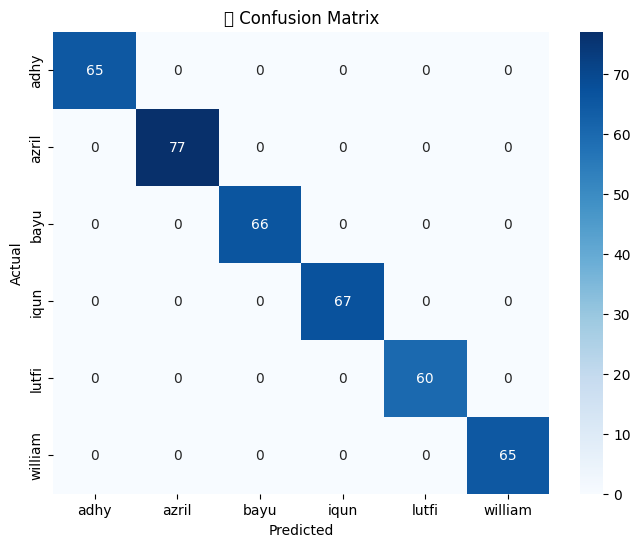

In [11]:
# Predictions
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test_enc, y_pred)
print(f"Accuracy: {acc:.4f}")

# F1 scores
f1_macro = f1_score(y_test_enc, y_pred, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred, average='weighted')
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# Classification report (optional)
print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [10]:
import joblib

joblib.dump((model, le), '/kaggle/working/facenet_svm_classifier.pkl')
print("Classifier saved as facenet_svm_classifier.pkl")

💾 Classifier saved as facenet_svm_classifier.pkl
